In [7]:
from dptb.nnops.trainer import Trainer
from dptb.data import ABACUSInMemoryDataset
from dptb.data.transforms import OrbitalMapper
from dptb.nn import build_model

from dptb.plugins.monitor import TrainLossMonitor, LearningRateMonitor
from dptb.plugins.train_logger import Logger
from dptb.plugins.plugins import Saver
import heapq
import logging
from dptb.utils.loggers import set_log_handles

common_options = {
    "basis": {
        "Ga": "2s2p2d1f",
        "N": "2s2p1d"
    },
    # "basis":{"Mo":"3s2p2d", "S":"2s2p1d"},
    "device": "cuda:0",
    "dtype": "float32",
    "overlap": False,
}

root = "/share/semicond/lmp_abacus/abacus_hse_data/GaN/prod-gan/GaN/sys-000/processed_GaN_pbe"
train_dataset = ABACUSInMemoryDataset(
    root=root,
    preprocess_dir="/share/semicond/lmp_abacus/abacus_hse_data/GaN/prod-gan/GaN/sys-000/processed_GaN_pbe",
    AtomicData_options={
        "r_max": 8.0,
        "er_max": None,
        "oer_max": None,
        "pbc": True,
    },
    type_mapper=OrbitalMapper(basis=common_options["basis"]),
)

train_options = {
    "seed": 12070,
    "num_epoch": 4000,
    "batch_size": 1,
    "optimizer": {
        "lr": 0.01,
        "type": "Adam",
    },
    "lr_scheduler": {
        "type": "exp",
        "gamma": 0.9995
    },
    "loss_options":{
        "train":{"method": "eigvals"}
    },
    "save_freq": 10,
    "validation_freq": 10,
    "display_freq": 1
}

run_opt = {
        "init_model": "/root/e3/local/refine_2_6lmax_6l/checkpoint/dptb.iter1001.pth",
        "restart": None,
        "freeze": False,
        "train_soc": False,
        "log_path": None,
        "log_level": None
    }

model_option = {
    "embedding": {
            "method": "e3baseline_local",
            "r_max": {"Ga":8.1, "N":7.1},
            "irreps_hidden": "32x0e+32x1o+16x2e+16x3o+16x4e+16x5o+8x6e",
            "lmax": 4,
            "n_layers": 4,
            "n_radial_basis": 18,
            "env_embed_multiplicity":1,
            "avg_num_neighbors": 63,
            "latent_kwargs": {
                "mlp_latent_dimensions": [128, 128, 256],
                "mlp_nonlinearity": "silu",
                "mlp_initialization": "uniform"
            }
        },
        "prediction":{
            "method": "e3tb",
            "scales_trainable":True,
            "shifts_trainable":True
        }
}

model = build_model(run_opt, {}, common_options)
model.to(common_options["device"])

model.eval()

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


DPTB(
  (embedding): E3BaseLineModelLocal(
    (sh): SphericalHarmonics()
    (onehot): OneHotAtomEncoding()
    (init_layer): InitLayer(
      (two_body_latent): ScalarMLPFunction(
        (_forward): RecursiveScriptModule(original_name=GraphModule)
      )
      (_env_weighter): Linear(1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e -> 1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e | 7 weights)
      (env_embed_mlp): ScalarMLPFunction(
        (_forward): RecursiveScriptModule(original_name=GraphModule)
      )
      (bessel): BesselBasis()
    )
    (layers): ModuleList(
      (0): Layer(
        (_env_weighter): Linear(1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e -> 1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e | 7 weights)
        (env_linears): Identity()
        (lin_pre): Linear(1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e -> 1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e | 7 weights)
        (activation): Gate (142x0e+32x1o+16x2e+16x3o+8x4e+4x5o+2x6e -> 64x0e+32x1o+16x2e+16x3o+8x4e+4x5o+2x6e)
        (tp): SeparateWeightTensorProduct(
        

In [8]:
np = 0
for p in model.parameters():
    np += p.view(-1).shape[0]

print(np)

993467


In [9]:
from dptb.data import AtomicData
from dptb.data.dataloader import DataLoader
import torch

loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)

for data in loader:
    ref_data = AtomicData.to_AtomicDataDict(data.to("cuda:0"))
    break
# ref_data = AtomicData.to_AtomicDataDict(train_dataset[dN].to("cuda:0"))
with torch.no_grad():
    data = model(ref_data)

In [10]:
from dptb.nnops.loss import HamilLossAnalysis

ana = HamilLossAnalysis(idp=model.idp, device=model.device, decompose=True)

ana_result = ana(data, ref_data)

rmse err for bond N-N: 0.021915080025792122 	 mae err for bond N-N: 0.008099161088466644
rmse err for bond N-Ga: 0.04044164717197418 	 mae err for bond N-Ga: 0.017163095995783806
rmse err for bond Ga-N: 0.03134715557098389 	 mae err for bond Ga-N: 0.009912804700434208
rmse err for bond Ga-Ga: 0.076223224401474 	 mae err for bond Ga-Ga: 0.03573114797472954
rmse err for atom N: 0.13477067649364471 	 mae err for bond N: 0.03793104737997055
rmse err for atom Ga: 0.19352763891220093 	 mae err for bond Ga: 0.052813541144132614


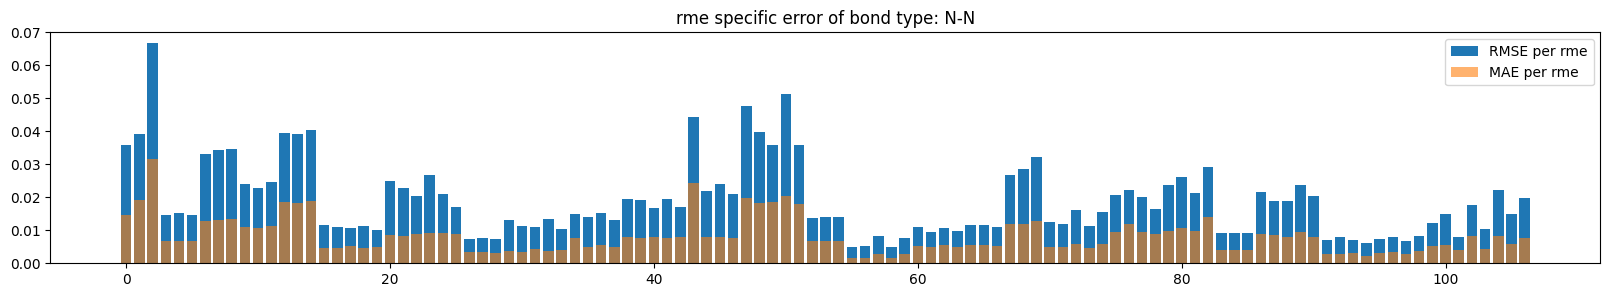

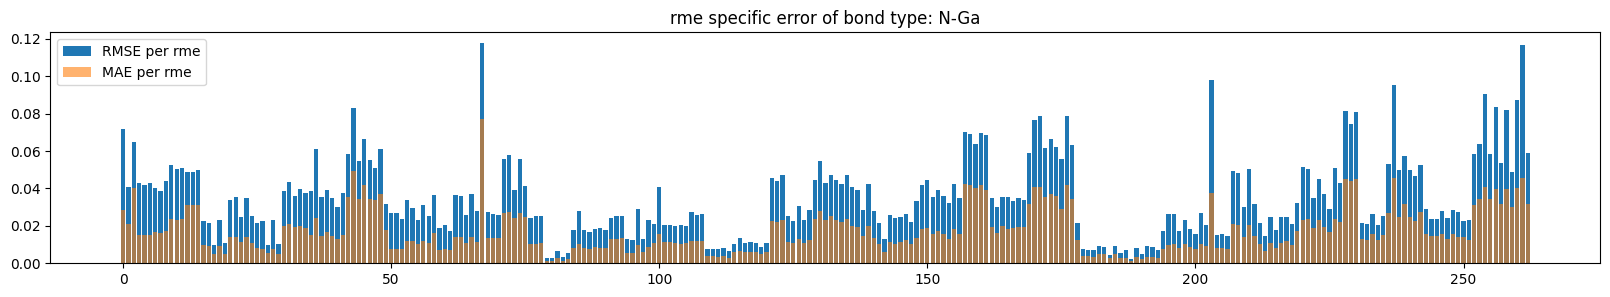

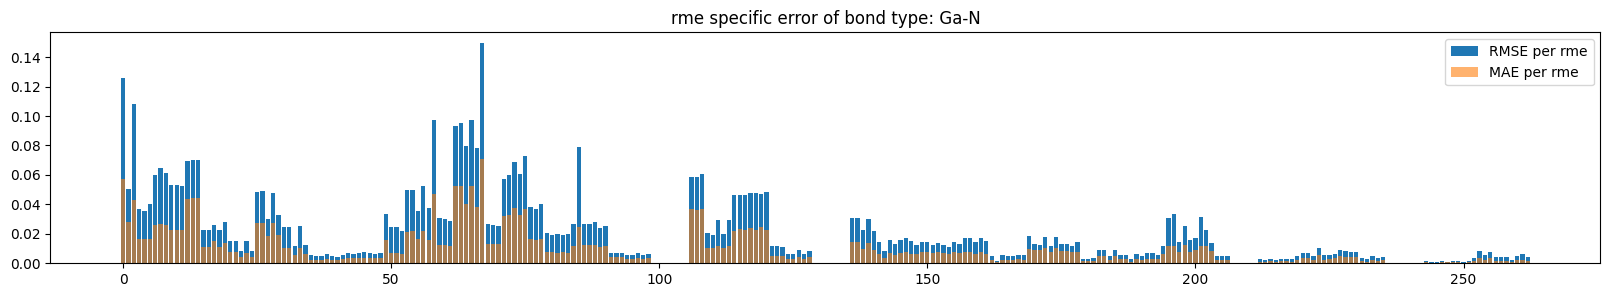

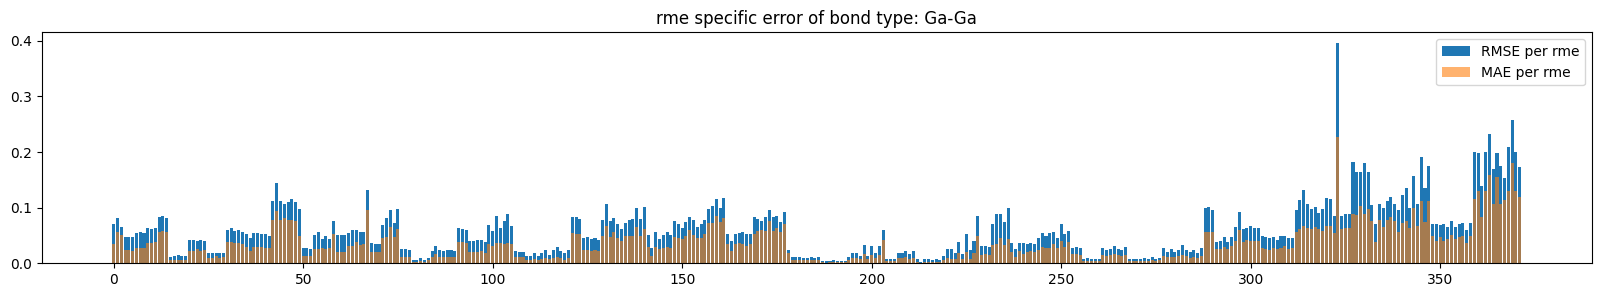

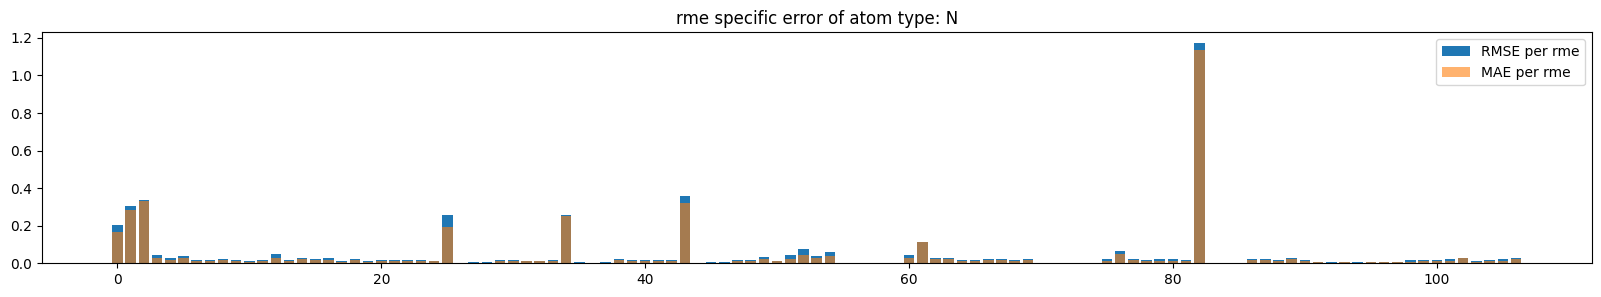

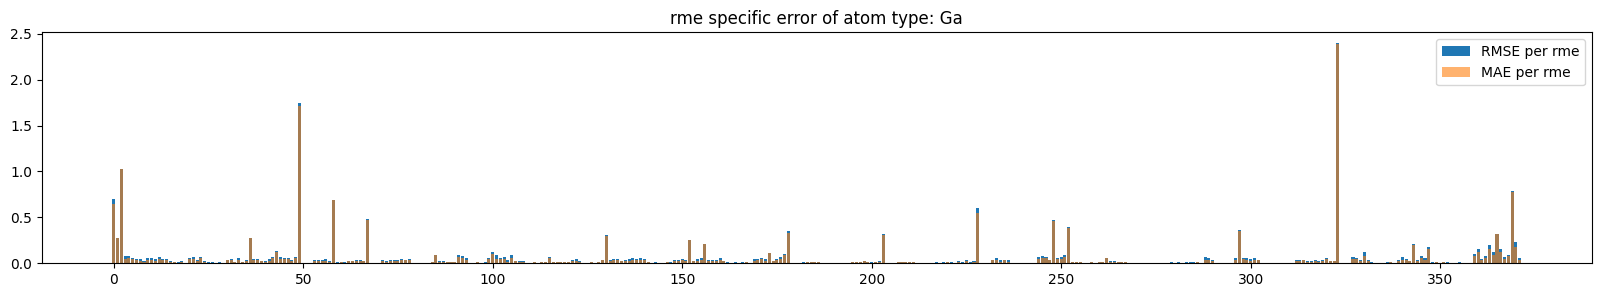

In [11]:
import matplotlib.pyplot as plt

for bt, err in ana_result["hopping"].items():
    print("rmse err for bond {bt}: {rmserr} \t mae err for bond {bt}: {maerr}".format(bt=bt, rmserr=err["rmse"], maerr=err["mae"]))

for bt, err in ana_result["onsite"].items():
    print("rmse err for atom {bt}: {rmserr} \t mae err for bond {bt}: {maerr}".format(bt=bt, rmserr=err["rmse"], maerr=err["mae"]))

for bt, err in ana_result["hopping"].items():
    x = list(range(len(err["rmse_per_block_element"])))
    rmserr = err["rmse_per_block_element"]
    maerr = err["mae_per_block_element"]
    # l1amp = err["l1amp"]
    # l2amp = err["l2amp"]

    plt.figure(figsize=(20,3))
    plt.bar(x, rmserr.cpu().detach(), label="RMSE per rme")
    plt.bar(x, maerr.cpu().detach(), alpha=0.6, label="MAE per rme")
    plt.legend()
    # plt.yscale("log")
    # plt.ylim([1e-5, 5e-2])
    plt.title("rme specific error of bond type: {bt}".format(bt=bt))
    plt.show()

    # plt.figure(figsize=(20,3))
    # plt.bar(x, l2amp.cpu().detach(), label="l2 amp per rme")
    # plt.bar(x, l1amp.cpu().detach(), alpha=0.6, label="l1 amp per rme")
    # plt.legend()
    # # plt.yscale("log")
    # # plt.ylim([1e-5, 5e-2])
    # plt.title("rme specific amp of bond type: {bt}".format(bt=bt))
    # plt.show()

for at, err in ana_result["onsite"].items():
    x = list(range(len(err["rmse_per_block_element"])))
    rmserr = err["rmse_per_block_element"]
    maerr = err["mae_per_block_element"]

    plt.figure(figsize=(20,3))
    plt.bar(x, rmserr.cpu().detach(), label="RMSE per rme")
    plt.bar(x, maerr.cpu().detach(), alpha=0.6, label="MAE per rme")
    plt.legend()
    # plt.yscale("log")
    # plt.ylim([1e-5, 5e-2])
    plt.title("rme specific error of atom type: {at}".format(at=at))
    plt.show()

    # l1amp = err["l1amp"]
    # l2amp = err["l2amp"]

    # plt.figure(figsize=(20,3))
    # plt.bar(x, l2amp.cpu().detach(), label="l2 amp per rme")
    # plt.bar(x, l1amp.cpu().detach(), alpha=0.6, label="l1 amp per rme")
    # plt.legend()
    # # plt.yscale("log")
    # # plt.ylim([1e-5, 5e-2])
    # plt.title("rme specific amp of atom type: {at}".format(at=at))
    # plt.show()

In [6]:
ana_result["onsite"]["Ga"]["rmse_per_block_element"].argmax()

tensor(178, device='cuda:0')

In [87]:
from dptb.nn.nnsk import NNSK
import json
from dptb.utils.tools import j_loader

from dptb.nn.hr2hk import HR2HK
from dptb.nn.energy import  Eigenvalues
from dptb.data import AtomicData, AtomicDataDict, ABACUSDataset
from dptb.data.transforms import OrbitalMapper
from ase.io import read, write
import matplotlib.pyplot as plt

dN = 141
atoms = train_dataset[dN].to_ase()

import numpy as np
from dptb.utils.make_kpoints import abacus_kpath

kpts = np.array([[0.0000000000,   0.0000000000,   0.0000000000,   30],   
                 [0.5000000000,   0.0000000000,   0.0000000000,   1],               
                 [0.0000000000,   0.5000000000,   0.0000000000,   30],    
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],     
                 [0.0000000000,   0.0000000000,   0.5000000000,   1],    
                 [-0.500000000,   -0.500000000,   0.5000000000,   30],                
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],               
                 [0.5000000000,   -0.500000000,   0.5000000000,   1],
                 [-0.500000000,   0.0000000000,   0.5000000000,   30],
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],
                 [0.5000000000,   -0.500000000,   0.0000000000,   1 ],
                 ])
kpoints, xlist, hsp = abacus_kpath(atoms, kpts)

import torch

data = train_dataset[dN].to_AtomicDataDict(train_dataset[dN].to(common_options["device"]))
data["kpoint"] = torch.from_numpy(kpoints).float().to(common_options["device"])

eigv = Eigenvalues(
    idp=model.idp,
    s_edge_field=AtomicDataDict.EDGE_OVERLAP_KEY,
    s_node_field=AtomicDataDict.NODE_OVERLAP_KEY,
    s_out_field=AtomicDataDict.OVERLAP_KEY,
    device=common_options["device"]
    )

model.eval()

data_predict = model(data.copy()).copy() # edge field is rme

# err = (eigv.h2k(data_predict.copy())["hamiltonian"]-eigv.h2k(data.copy())["hamiltonian"]).abs()
# plt.hist(err.flatten().detach().cpu(), bins=100, log=True)
# # plt.xscale("log")
# plt.show()

In [88]:
data = eigv(data).copy()
data_predict["edge_overlap"] = data["edge_overlap"]
data_predict = eigv(data_predict)

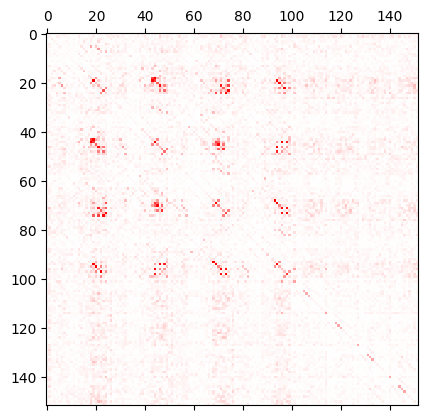

In [89]:
import matplotlib.pyplot as plt
plt.matshow((data_predict["hamiltonian"] - data["hamiltonian"])[0].detach().abs().cpu().numpy(), cmap="bwr", vmin=-0.5, vmax=0.5)
plt.show()

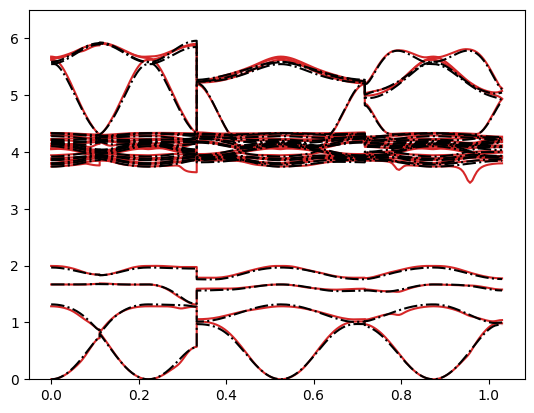

In [93]:
import matplotlib.pyplot as plt

plt.plot(xlist, data_predict["eigenvalue"].detach().cpu()-data_predict["eigenvalue"].detach().min().cpu(), c="tab:red")
plt.plot(xlist, data["eigenvalue"].detach().cpu()-data["eigenvalue"].detach().min().cpu(), "-.", c="black")
plt.ylim(0,6.5)
plt.show()

In [34]:
import numpy as np
from dptb.postprocess.bandstructure.band import Band

band = Band(
    model=model,
    use_gui=True,
    device=common_options["device"],
    overlap=False,
)

kpts = np.array([[0.0000000000,   0.0000000000,   0.0000000000,   30],   
                 [0.5000000000,   0.0000000000,   0.0000000000,   1],               
                 [0.0000000000,   0.5000000000,   0.0000000000,   30],    
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],     
                 [0.0000000000,   0.0000000000,   0.5000000000,   1],    
                 [-0.500000000,   -0.500000000,   0.5000000000,   30],                
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],               
                 [0.5000000000,   -0.500000000,   0.5000000000,   1],
                 [-0.500000000,   0.0000000000,   0.5000000000,   30],
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],
                 [0.5000000000,   -0.500000000,   0.0000000000,   1 ],
                 ])

band.get_bands(
    data=train_dataset[0], 
    kpath_kwargs={
        "kline_type": "abacus",
        "kpath":kpts, 
        "klabels": ["G", "X/Y", "X/Y", "G", "Z", "R_2", "G", "T_2/U_2", "T_2/U_2", "G", "V_2"]
        }
    )

{'klist': array([[ 0.        ,  0.        ,  0.        ],
        [ 0.01666667,  0.        ,  0.        ],
        [ 0.03333333,  0.        ,  0.        ],
        [ 0.05      ,  0.        ,  0.        ],
        [ 0.06666667,  0.        ,  0.        ],
        [ 0.08333333,  0.        ,  0.        ],
        [ 0.1       ,  0.        ,  0.        ],
        [ 0.11666667,  0.        ,  0.        ],
        [ 0.13333333,  0.        ,  0.        ],
        [ 0.15      ,  0.        ,  0.        ],
        [ 0.16666667,  0.        ,  0.        ],
        [ 0.18333333,  0.        ,  0.        ],
        [ 0.2       ,  0.        ,  0.        ],
        [ 0.21666667,  0.        ,  0.        ],
        [ 0.23333333,  0.        ,  0.        ],
        [ 0.25      ,  0.        ,  0.        ],
        [ 0.26666667,  0.        ,  0.        ],
        [ 0.28333333,  0.        ,  0.        ],
        [ 0.3       ,  0.        ,  0.        ],
        [ 0.31666667,  0.        ,  0.        ],
        [ 0

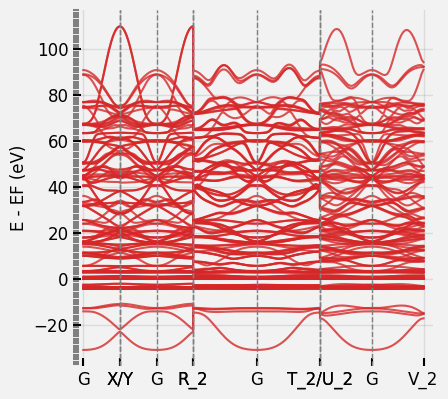

In [6]:
band.band_plot(E_fermi=0.)

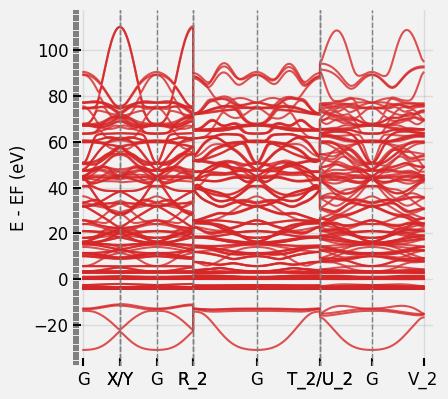

In [10]:
band.band_plot(E_fermi=0.)